In [1]:
#######################################################################
# Loading packages
#######################################################################
using MatrixNetworks
using Distributions
using Clustering
using NPZ
using BenchmarkTools, Compat
using DelimitedFiles
using SparseArrays
using Printf
using LinearAlgebra
using Plots
#######################################################################
# Loading functions
#######################################################################
include("Algo/SphereEmbedCluster.jl")


SDP_Cluster (generic function with 1 method)

In [2]:
#######################################################################
# Loading data for the first call (used for compilation
#######################################################################
community0 = readdlm("Data/LFR_NMI_2/precompile.nmc"); # communities: .nmc
adj = readdlm("Data/LFR_NMI_2/precompile.nse"); # network: *.nse

# remove first line (infos) and third column (weights)
adj = adj[2:end,1:2]
adj = convert(Array{Float64,2},adj)

community_true = community0[:,2];
N = length(community_true);
n_edge2 = size(adj)[1];

A = sparse(adj[:,1],adj[:,2],vec(ones(Int64,n_edge2,1)),N,N);
A = A+A' # Only the upper triangular part of A was stored
A,_ = largest_component(A);
adj = 0;

#######################################################################
# First call to compile the functions
#######################################################################
print("------------ First Run for Compilation ------------- \n")

n_it_PPM = 2;
t = 1e-06;
n_clusters = 2;
n_it_Vec_Partition = 3;
shape = "Ellipsoidal"; #shape = "Spherical"
r0 = 20;

n_updates = 1;
sig,community =  SphereEmbedCluster(A,n_it_PPM,t, n_clusters,n_it_Vec_Partition,n_updates,shape,r0);

	print("\n------------ DONE: TEST OK ------------- \n")
#######################################################################

------------ First Run for Compilation ------------- 

 ------- Acc Projected Power Iteration -------
The iteration did not converge after 2 iterations
The relative difference between the last objective values 0.072783 
  0.068251 seconds (36.21 k allocations: 1.960 MiB)
OK 
 -------------- Clustering ------- 
dimension of embedding used for clustering: 20
Number of updates: 1
Number of communities: 2
Modularity: 0.08571404786680542
 -------------------------------------------- 
The squared singular values divided by N : 
[0.37102288665408395, 0.2451317403891235, 0.09598608740636609, 0.05126789659083252, 0.033320198069523944, 0.026813313976495144, 0.0241276246087647, 0.02021705197298837, 0.019169699802655208, 0.016604443634880145, 0.01556534499268569, 0.01546825368657747, 0.013357703055958394, 0.011783715529504921, 0.010643953640408559, 0.009279389415040041, 0.007692147428591931, 0.006248990123497594, 0.003972301535392116, 0.002327257486629749]

------------ DONE: TEST OK -------------

In [4]:
println("Parameters given to LFR generator to generate the graphs (can be different:")
println("   Number of nodes: 1000\n   Average degree: 10\n   maximum degree 20\n   mu_weight in 0.1:0.1:1")
println("   Other parameters have default values:")
println("   tau_1=2\n   tau_2=1\n   on=0 (number of overlapping nodes)\n   om=0 (number of memberships of the overlapping nodes)\n   beta=1.5\n   mu_topology=mu_weight\n   minc and maxc will be chosen close to the degree sequence extremes")
println("The weights of the graphs are ignored.")

Parameters given to LFR generator to generate the graphs (can be different:
   Number of nodes: 1000
   Average degree: 10
   maximum degree 20
   mu_weight in 0.1:0.1:1
   Other parameters have default values:
   tau_1=2
   tau_2=1
   on=0 (number of overlapping nodes)
   om=0 (number of memberships of the overlapping nodes)
   beta=1.5
   mu_topology=mu_weight
   minc and maxc will be chosen close to the degree sequence extremes
The weights of the graphs are ignored.



========== Graph 1/10, mu=0.1, number_rep = 1 ==========

 ------- Acc Projected Power Iteration -------
The iteration has become stationary after 378 iterations
  2.229227 seconds (9.98 k allocations: 1.023 GiB, 31.68% gc time)
OK 
 -------------- Clustering ------- 
dimension of embedding used for clustering: 40
Number of updates: 4
Number of communities: 19
Modularity: 0.8503160234694015
 -------------------------------------------- 
The squared singular values divided by N : 
[0.33853249336245894, 0.1937052546287414, 0.16149679577886905, 0.1383565617161404, 0.1186786905089131, 0.03581332650569848, 0.013235741610322118, 8.520058246869243e-5, 5.118810006794289e-5, 2.000327592777074e-5, 1.3599391370367883e-5, 3.7339065198783024e-6, 2.793984730443135e-6, 1.7518827409964997e-6, 1.0472191207086447e-6, 5.010627431710094e-7, 3.7170529781547157e-7, 2.437752666947563e-7, 1.8059811949471194e-7, 1.4133373258188238e-7, 1.0078601028234935e-7, 7.726465692584177e-8, 7.687026627129601e-8, 5.577852

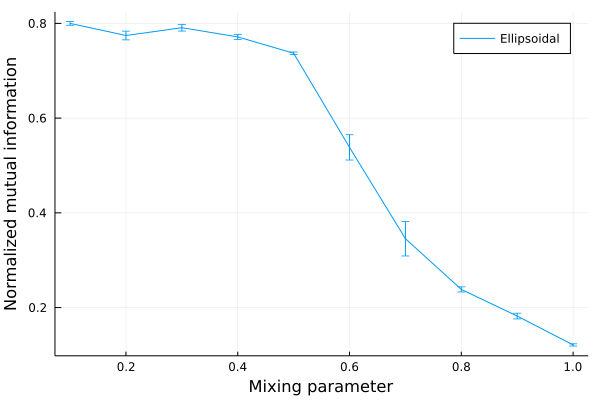

In [5]:
#######################################################################
# Compute NMI for each graph
#######################################################################

# Set parameters of simulations
mus=0.1:0.1:1 # values for the mixing parameter

n_it_PPM = 30000;
t = 1e-10;
n_clusters = 20;
r0 = 40;

# Specify here the number of times vector partition is repeated
n_it_Vec_Partition = 10;
# we advise : n_it_Vec_Partition = 100;

n_updates = 100; # max total by default
shape = "Ellipsoidal"; #shape = "Spherical"

n_rep = 2;
NMIs=zeros(Float64,length(mus),n_rep)
for i=1:length(mus)
    for j=1:n_rep
        println("\n========== Graph $i/$(length(mus)), mu=$(mus[i]), number_rep = $j ==========")
        # load graph data
        community0 = readdlm("Data/LFR_NMI_2/data"*string(mus[i])*".nmc"); # communities: .nmc
        adj = readdlm("Data/LFR_NMI_2/data"*string(mus[i])*".nse"); # network: *.nse
        
        # remove first line (infos) and third column (weights)
        adj = adj[2:end,1:2]
        adj = convert(Array{Float64,2},adj)

        community_true = convert(Array{Int64},community0[:,2])
        N = length(community_true);
        n_edge2 = size(adj)[1];

        A = sparse(adj[:,1],adj[:,2],vec(ones(Int64,n_edge2,1)),N,N);
        A = A+A' # Only the upper triangular part of A was stored

        A,vertices = largest_component(A);
        community_true=community_true[vertices]
        community_true=Reorder(community_true)

        # solve
        ~,community = @time SphereEmbedCluster(A,n_it_PPM,t, n_clusters,n_it_Vec_Partition,n_updates,shape,r0)

        # compute NMI
        NMIs[i,j]=mutualinfo(community_true,community);
    end
end
#######################################################################
# Plot Normalized mutual information vs Miwing parameter
#######################################################################
m = mean(NMIs,dims=2);
s = std(NMIs,dims=2);
plot(mus, m, yerror = s,
markerstrokecolor=:auto,
xlabel = "Mixing parameter",
ylabel = "Normalized mutual information",
labels = "Ellipsoidal")
#######################################################################

